# Assignment - 18 (Forecasting)

## 1. Airlines Data
Forecast Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

ModuleNotFoundError: No module named 'plotly'

In [3]:
# Import Dataset
df = pd.read_excel('C:/Users/malho/Downloads/Airlines+Data.xlsx')
print('Shape of the data',df.shape)
df.head(10)

Shape of the data (96, 2)


Month  Passengers
0 1995-01-01         112
1 1995-02-01         118
2 1995-03-01         132
3 1995-04-01         129
4 1995-05-01         121
5 1995-06-01         135
6 1995-07-01         148
7 1995-08-01         148
8 1995-09-01         136
9 1995-10-01         119

#### EDA

In [3]:
df.isnull().any()

Month         False
Passengers    False
dtype: bool

In [4]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

<AxesSubplot:>

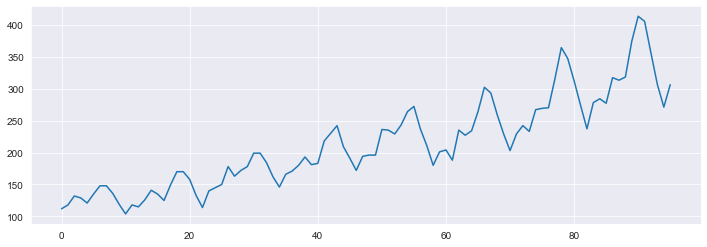

In [5]:
df.Passengers.plot(figsize=(12,4))

In [6]:
df.shape

(96, 2)

In [7]:
#Checking the data types
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [8]:
#Unique values for every feature
df.nunique()

Month         96
Passengers    80
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [10]:
df[df.duplicated()].shape

(0, 2)

In [11]:
df[df.duplicated()]

Empty DataFrame
Columns: [Month, Passengers]
Index: []

In [12]:
# Descriptive Analysis
df.describe()

Passengers
count   96.000000
mean   213.708333
std     71.918216
min    104.000000
25%    156.000000
50%    200.000000
75%    264.750000
max    413.000000

In [13]:
# Renaming the Month column into Date
df.rename({'Month':'Date'},axis=1, inplace=True)

In [14]:
# Making the Date as DateTime index for the Dataframe
df1 = df.copy()
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [15]:
df1.head()

Passengers
Date                  
1995-01-01         112
1995-02-01         118
1995-03-01         132
1995-04-01         129
1995-05-01         121

In [16]:
# Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

Date  Passengers month  year
0 1995-01-01         112   Jan  1995
1 1995-02-01         118   Feb  1995
2 1995-03-01         132   Mar  1995
3 1995-04-01         129   Apr  1995
4 1995-05-01         121   May  1995
5 1995-06-01         135   Jun  1995
6 1995-07-01         148   Jul  1995
7 1995-08-01         148   Aug  1995
8 1995-09-01         136   Sep  1995
9 1995-10-01         119   Oct  1995

#### Visualization

<AxesSubplot:xlabel='month', ylabel='year'>

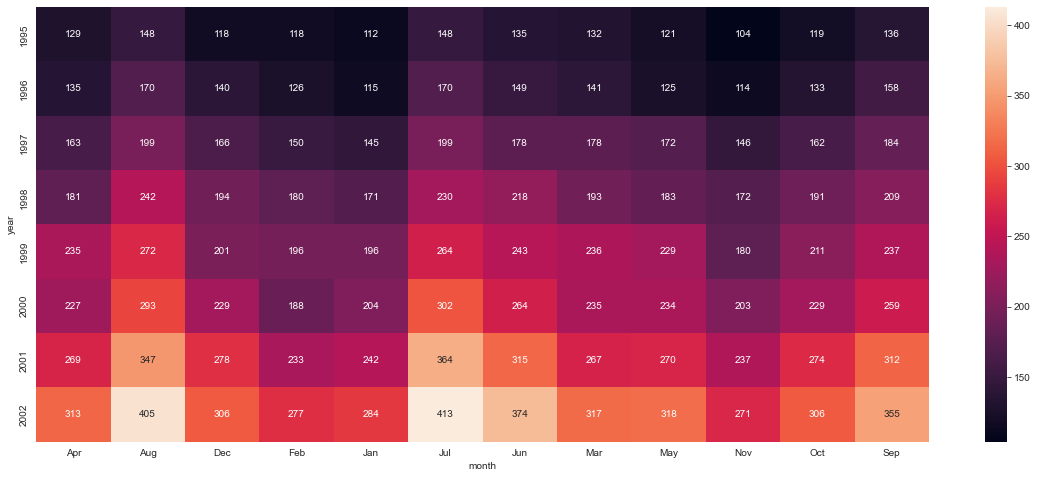

In [17]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

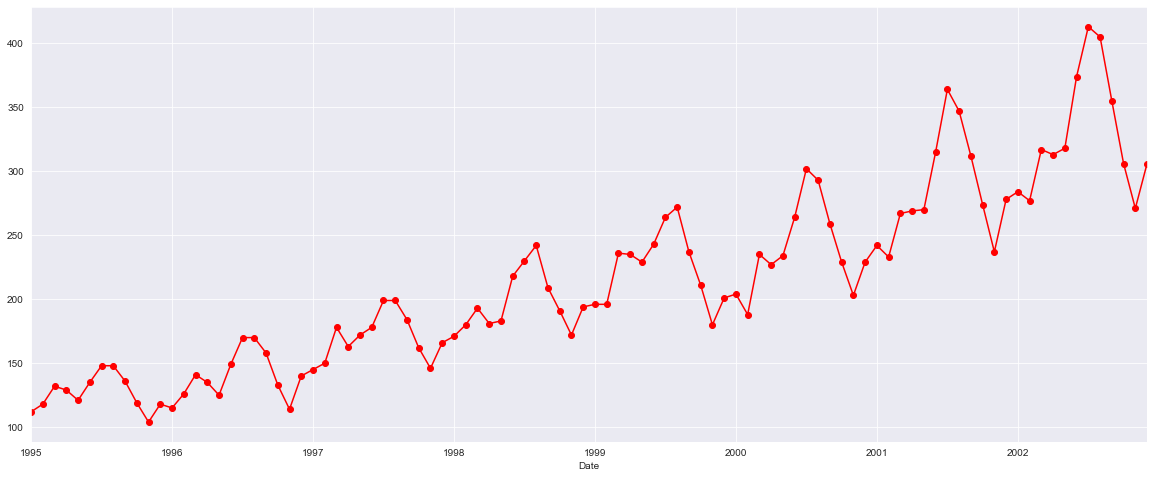

In [18]:
# Line plot
df1['Passengers'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

Observation:
1. We can see that there is an increasing Trend. So, Trend is not constant.
2. Variance is also not constant.

Hence the time serise is not stationary.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


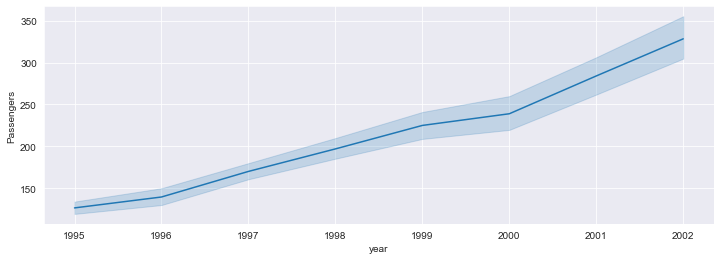

In [19]:
# Yearly Passenger Analysis
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Passengers",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

<AxesSubplot:xlabel='year', ylabel='Passengers'>

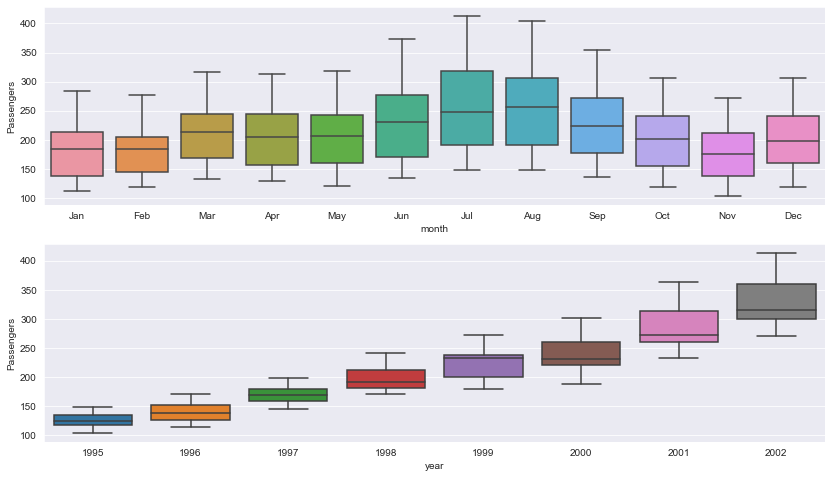

In [20]:
# Box Plot of Each Year by Monthly Intervals
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=df)

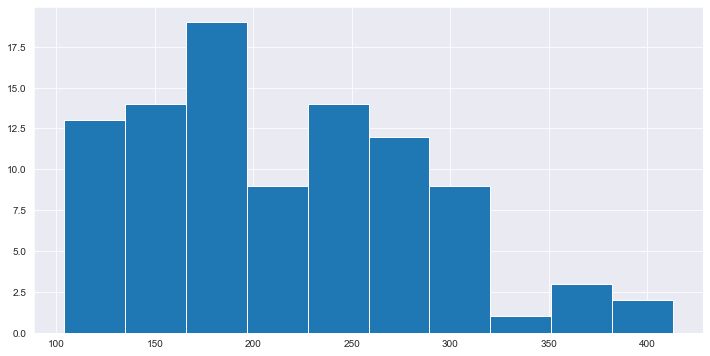

In [21]:
# Histogram and Density Plots
df.Passengers.hist(figsize=(12,6))
plt.show()

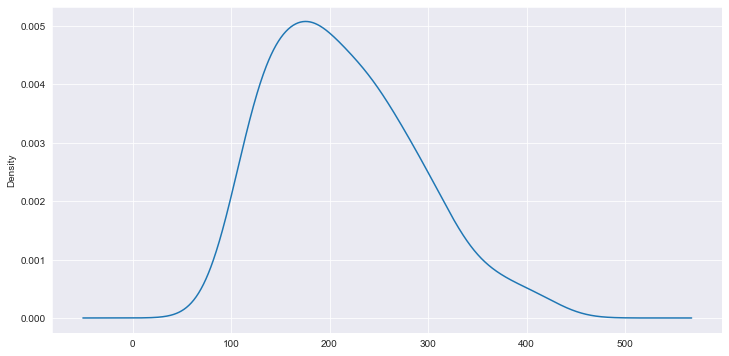

In [22]:
# create a density plot
df.Passengers.plot(kind='kde', figsize=(12,6))
plt.show()

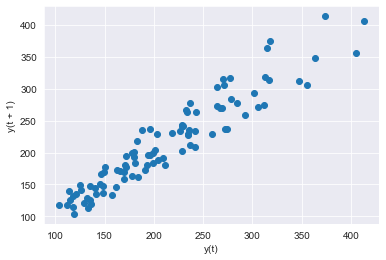

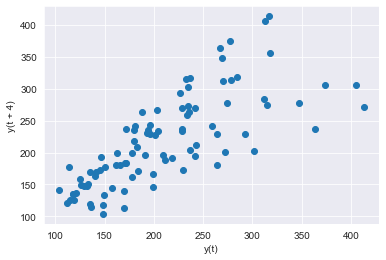

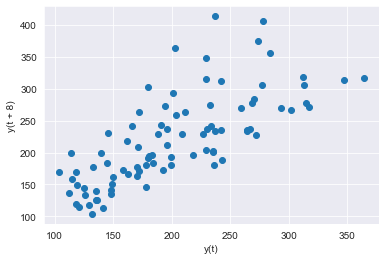

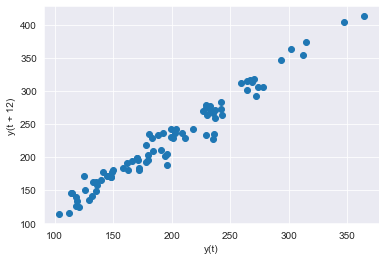

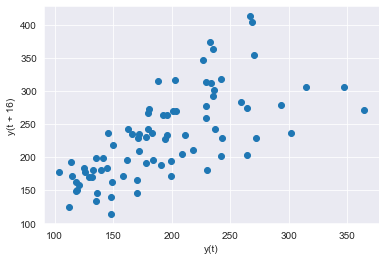

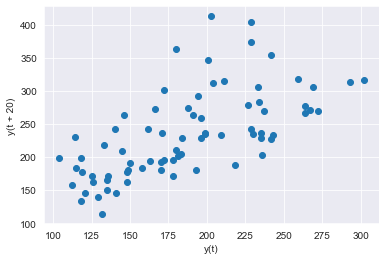

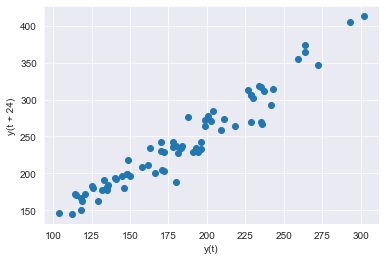

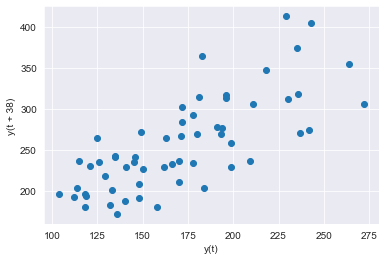

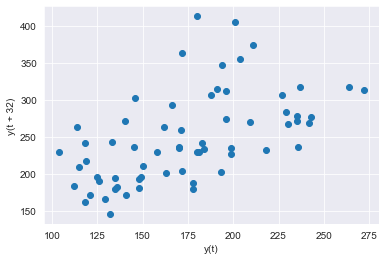

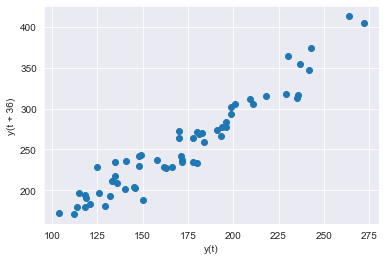

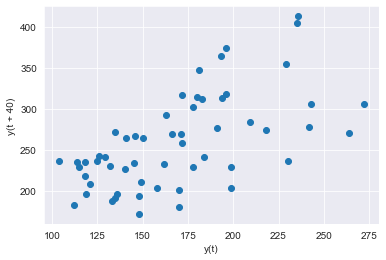

In [23]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

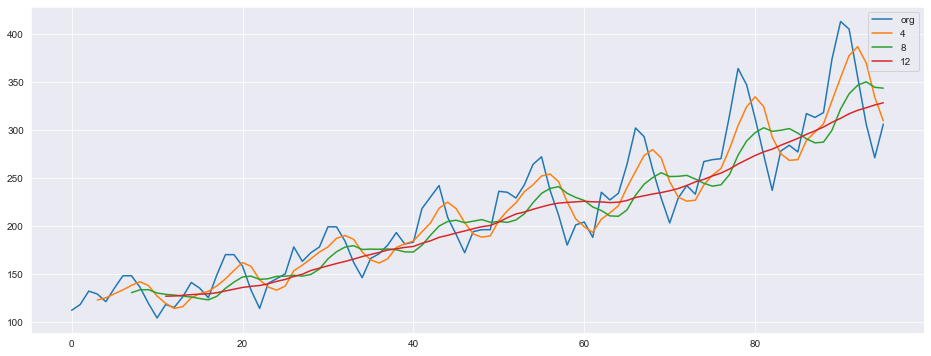

In [24]:
# Moving Average
plt.figure(figsize=(16,6))
df.Passengers.plot(label="org")
for i in range(4,13,4):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

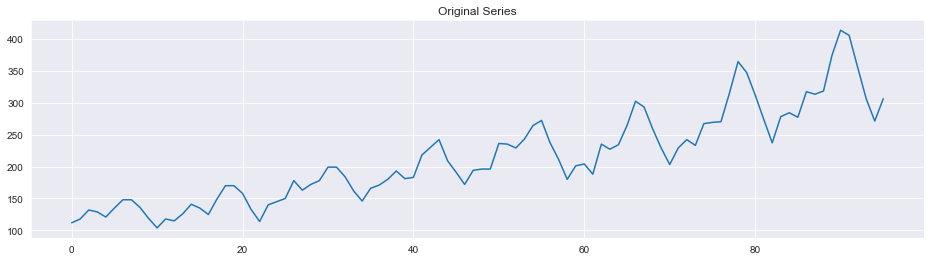

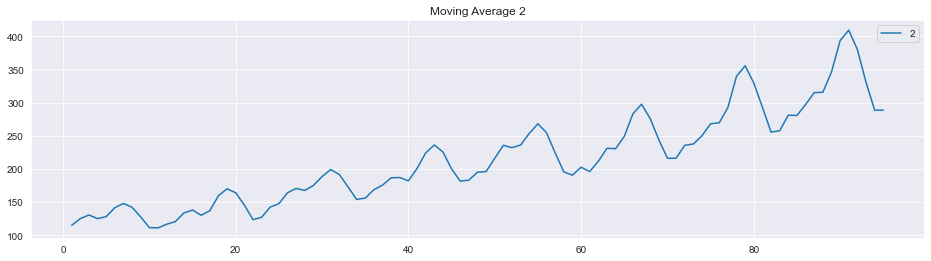

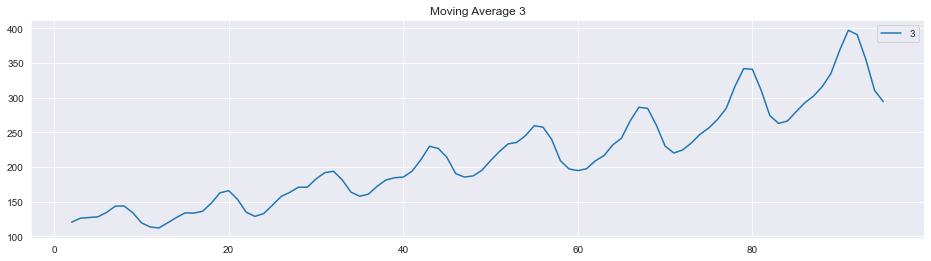

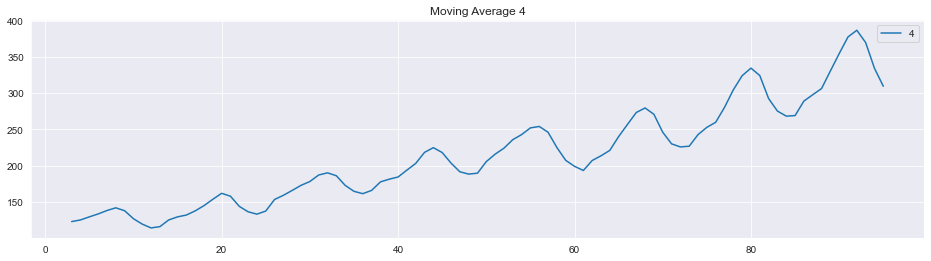

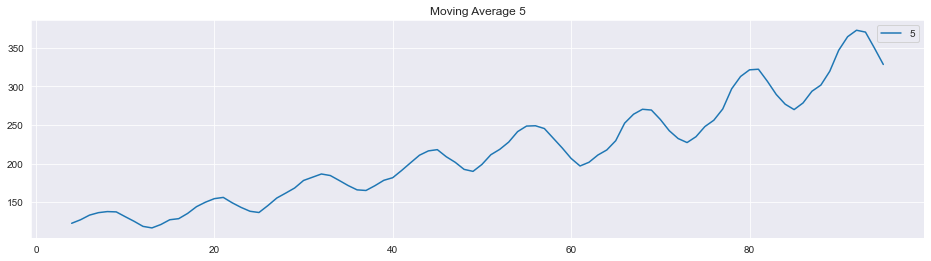

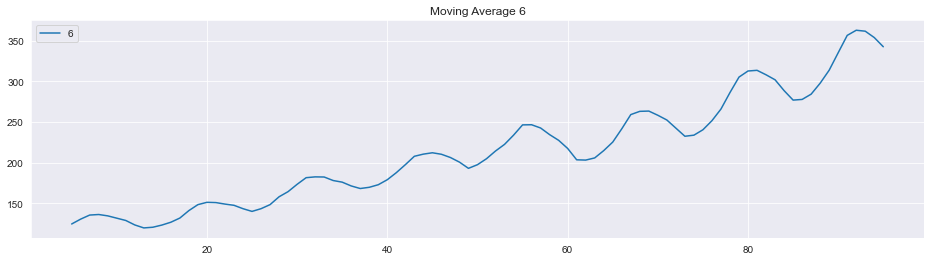

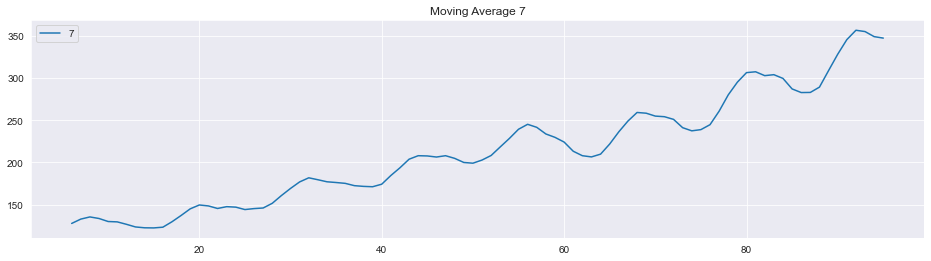

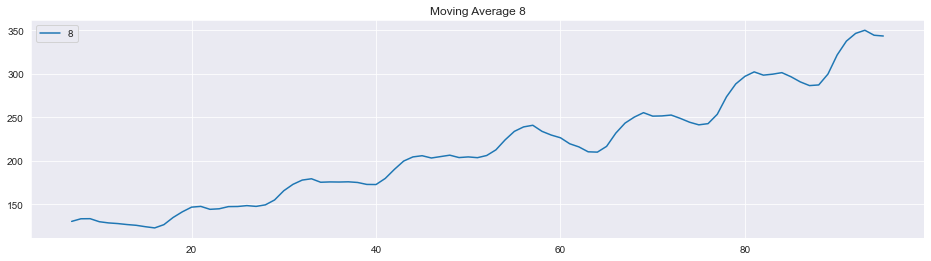

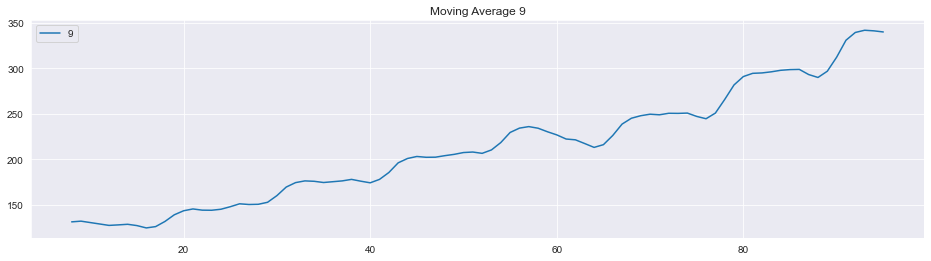

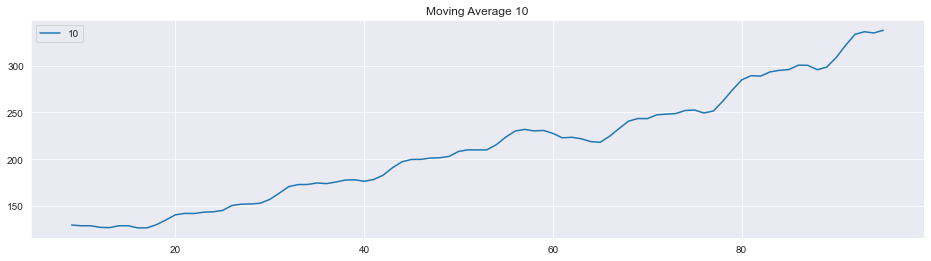

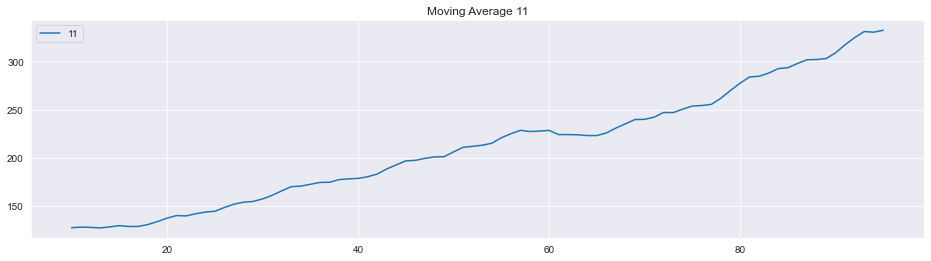

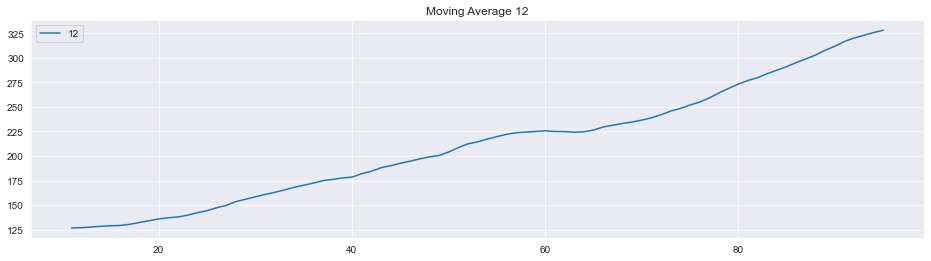

In [25]:
plt.figure(figsize=(16,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

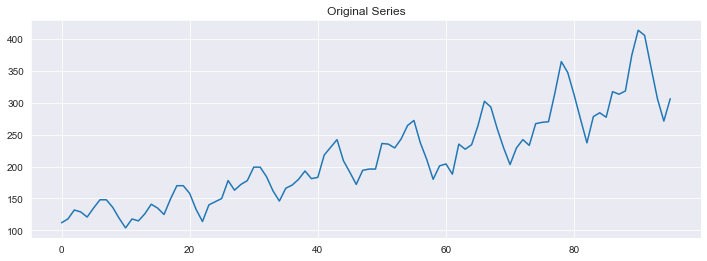

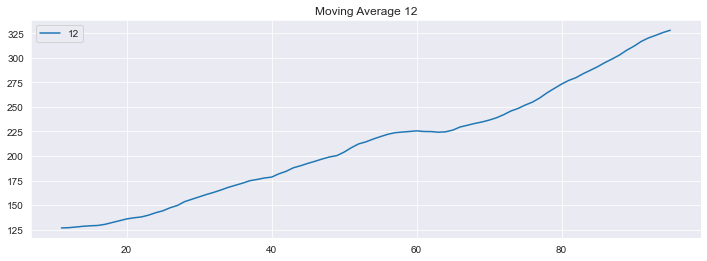

In [26]:
plt.figure(figsize=(12,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

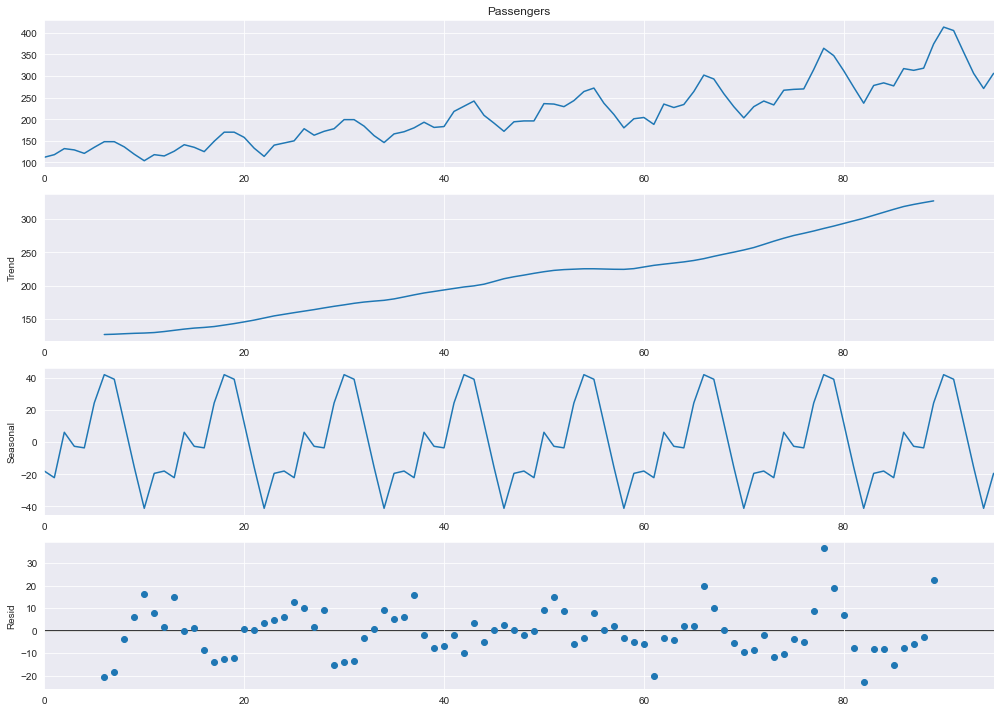

In [27]:
# Time series decomposition plot 
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

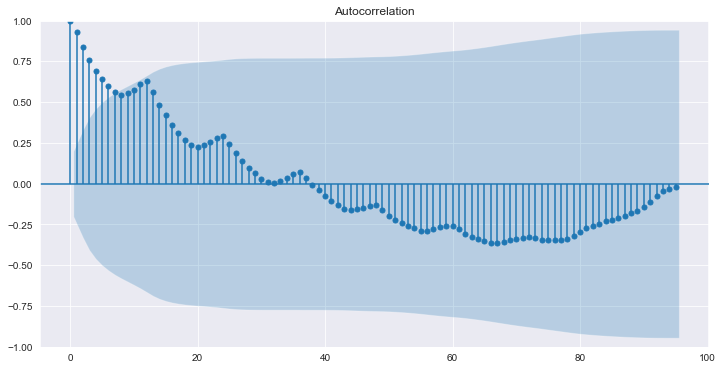

In [28]:
# ACF(Autocorrelation function) plots and PACF(Partial Auto correlation function) plots
# ACF
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()

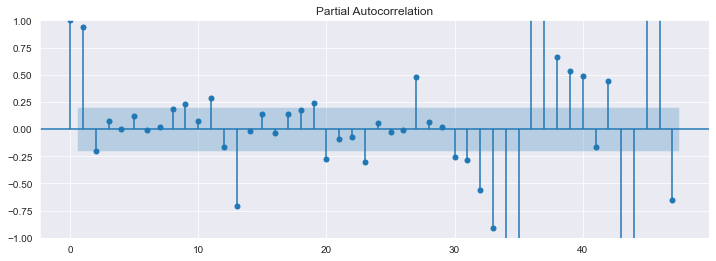

In [29]:
# PACF
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

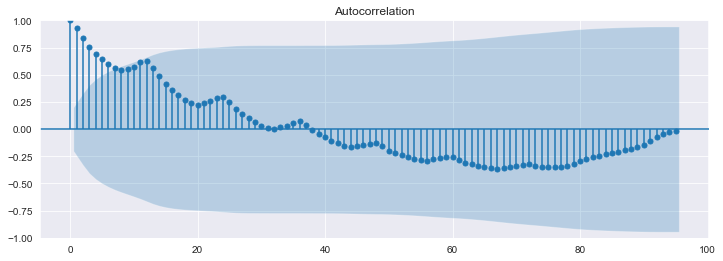

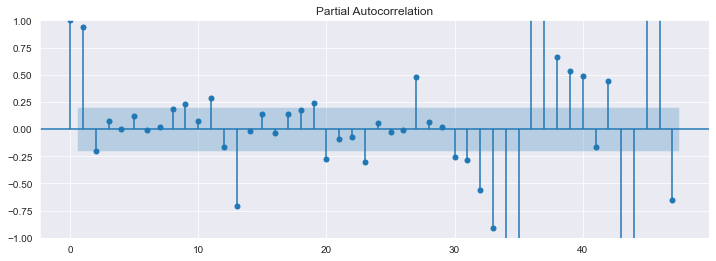

In [30]:
# To summarize, a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

In [31]:
visual = df1.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual.head(10)

Passengers       date  year  month  week  quarter day_of_week
0         112 1995-01-01  1995      1    52        1      Sunday
1         118 1995-02-01  1995      2     5        1   Wednesday
2         132 1995-03-01  1995      3     9        1   Wednesday
3         129 1995-04-01  1995      4    13        2    Saturday
4         121 1995-05-01  1995      5    18        2      Monday
5         135 1995-06-01  1995      6    22        2    Thursday
6         148 1995-07-01  1995      7    26        3    Saturday
7         148 1995-08-01  1995      8    31        3     Tuesday
8         136 1995-09-01  1995      9    35        3      Friday
9         119 1995-10-01  1995     10    39        4      Sunday

In [32]:
visual.year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002], dtype=int64)

In [33]:
# data 
df_1995 = visual[visual['year']==1995][['month','Passengers']]
df_1995 = df_1995.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1995'})
df_1996 = visual[visual['year']==1996][['month','Passengers']]
df_1996 = df_1996.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1996'})
df_1997 = visual[visual['year']==1997][['month','Passengers']]
df_1997 = df_1997.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1997'})
df_1998 = visual[visual['year']==1998][['month','Passengers']]
df_1998 = df_1998.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1998'})
df_1999 = visual[visual['year']==1999][['month','Passengers']]
df_1999 = df_1999.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'1999'})
df_2000 = visual[visual['year']==2000][['month','Passengers']]
df_2000 = df_2000.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2000'})
df_2001 = visual[visual['year']==2001][['month','Passengers']]
df_2001 = df_2001.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2001'})
df_2002 = visual[visual['year']==2002][['month','Passengers']]
df_2002 = df_2002.groupby('month').agg({"Passengers" : "mean"}).reset_index().rename(columns={'Passengers':'2002'})



df_year = df_1995.merge(df_1996,on='month').merge(df_1997,on='month').merge(df_1998,on='month').merge(df_1999,on='month')\
.merge(df_2000,on='month').merge(df_2001,on='month').merge(df_2002,on='month')

# top levels
top_labels = ['1995', '1996', '1997', '1998', '1999','2000','2001','2002']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)']

# X axis value 
df_year = df_year[['1995', '1996', '1997', '1998', '1999','2000','2001','2002']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1995['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1995['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

        
fig.update_layout(title='Avg Passengers for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

Observation:

+ Highest sales are made in August and July month and then decreases in December.
+ Sales are increasing gradually from 1995 to 2002.

In [34]:
# data
import calendar
df_m_sa = visual.groupby('month').agg({"Passengers" : "mean"}).reset_index()
df_m_sa['Passengers'] = round(df_m_sa['Passengers'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Passengers'].astype(str) 

df_w_sa = visual.groupby('week').agg({"Passengers" : "mean"}).reset_index() 
df_q_sa = visual.groupby('quarter').agg({"Passengers" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Passengers Analysis", "Quarter wise Avg Passengers Analysis", 
                                    "Week wise Avg Passengers Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['Passengers'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Passengers'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Passengers'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Passengers Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

In [35]:
# data
df_dw_sa = visual.groupby('day_of_week').agg({"Passengers" : "mean"}).reset_index()
df_dw_sa.Passengers = round(df_dw_sa.Passengers, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Passengers', title='Avg Passengers vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='Passengers',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

Observation:

+ As we saw in the above chart there is an upward trend in Number of Passengers over the time. Although there are ups and downs at every point in time, generally we can observe that the trend increases. Also we can notice how the ups and downs seem to be a bit regular, it means we might be observing a seasonal pattern here too. Let’s take a closer look by observing some year’s data:
+ Highest sales are made on Thursday.
+ July month has the highest sales.

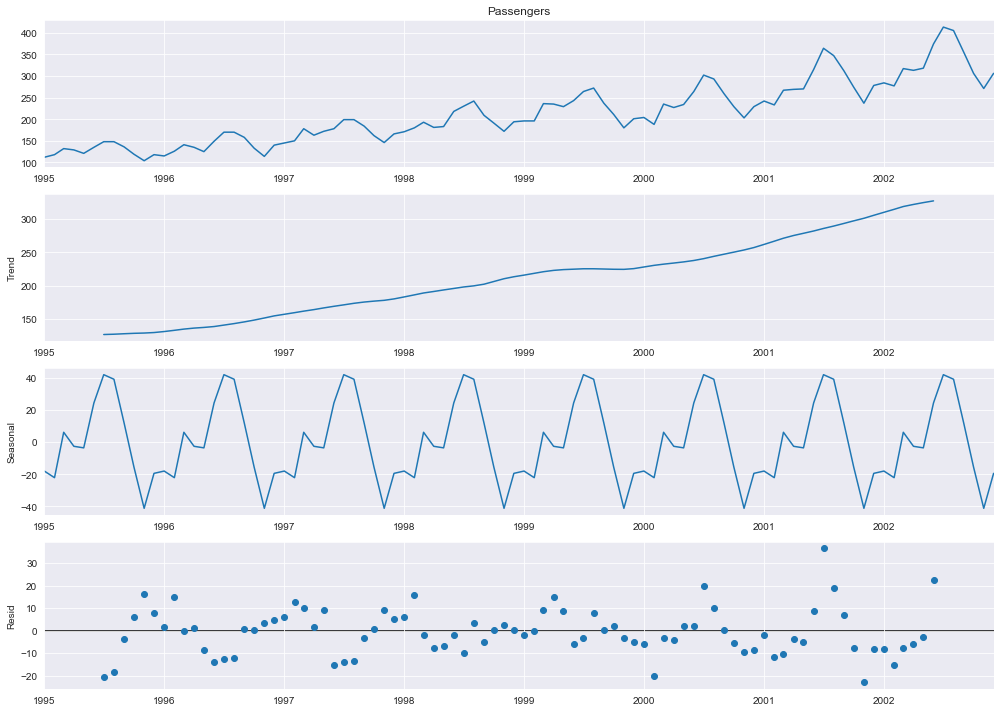

In [36]:
# Additive Seasonal Decomposition
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

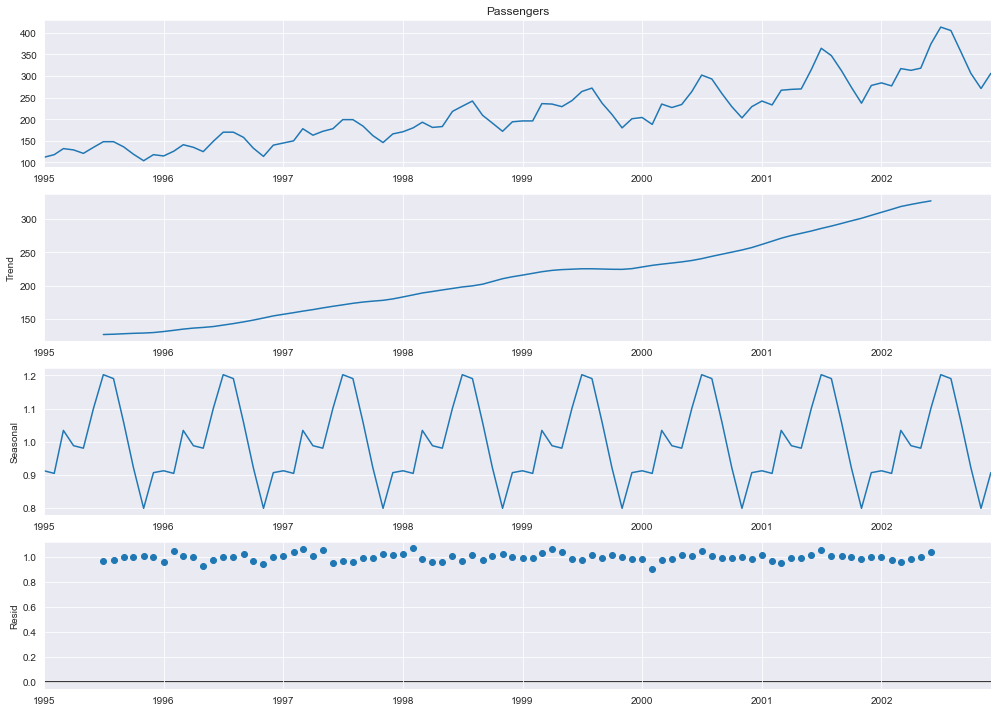

In [37]:
# Multiplicative Seasonal Decomposition
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

#### Splitting Train and Test Data
#### Leaving Test Data with 2 Years of Time Series

In [38]:
size = 72
train_data = df1[:size]
test_data = df1[size:]

In [39]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


We are going to forecat for the last two years. 2001 and 2002.

Last 24 records contain From 2001 to 2002 data.

<AxesSubplot:xlabel='Date'>

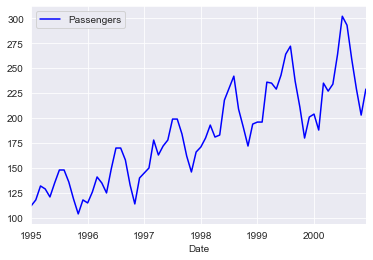

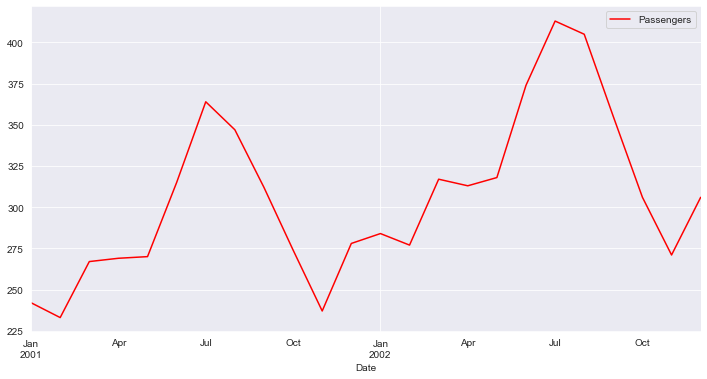

In [40]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

In [41]:
# Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

#### Exponential Methods

In [42]:
# Simple Exponential Method
# Using Forecast Attribute
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 23.382283350044727 
 Train Root Mean Squared Error = 19.031771730910982 
 Test Root Mean Squared Error = 91.11325402904403


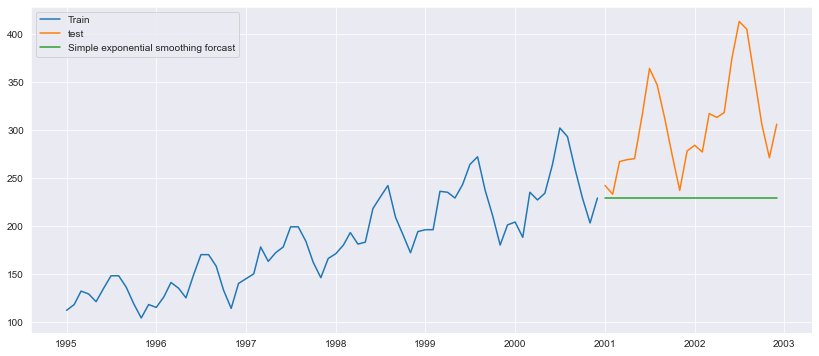

In [43]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

Observation
1. No seasonality captures.
2. Most recent observation gets higher weightages than the older ones for forecasting.

In [44]:
# Holt method (Double Exponential) 
# Captures both Level and Trend
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Passengers))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 17.148981696358685 
 Train Root Mean Squared Error = 18.96128999459111 
 Test Root Mean Squared Error = 71.63464300883933


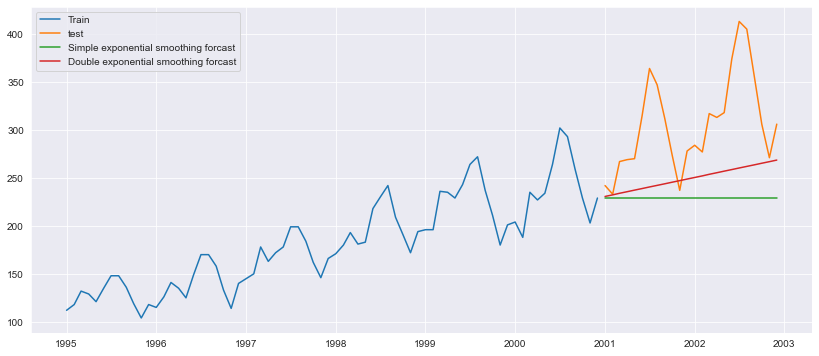

In [45]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

Observation
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

In [46]:
# Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)
# Captures Level, Trend and Seasonality.
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Passengers))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 12.084508619943344 
 Train Root Mean Squared Error = 7.75130351137479 
 Test Root Mean Squared Error = 47.5692832638379


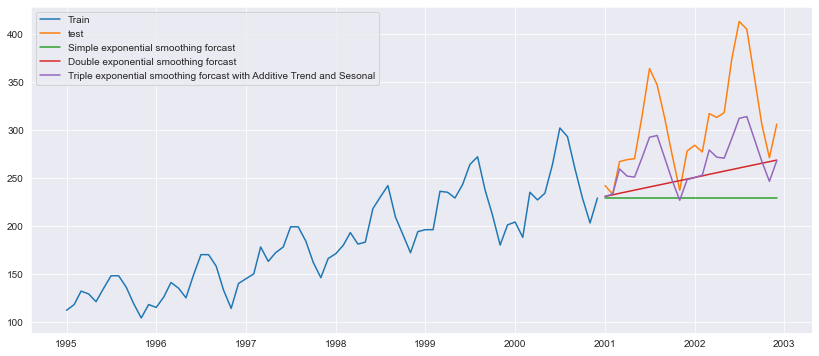

In [47]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

Observation
1. It captures the trend, which we can see that the forecasted values are lower level than the test level.
2. It also captures the seasonality.
3. The peak of the forecasted value is lower than the actual.

In [48]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Passengers))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 9.368354573562144 
 Train Root Mean Squared Error = 6.386634437793857 
 Test Root Mean Squared Error = 34.989365374325125


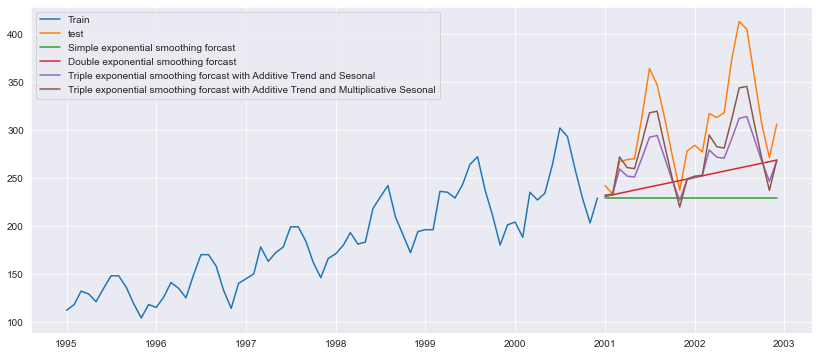

In [49]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

Observation
1. We can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

In [50]:
# Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Passengers))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Passengers)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 12.932828408981296 
 Train Root Mean Squared Error = 12.749205006763182 
 Test Root Mean Squared Error = 46.72864658311806


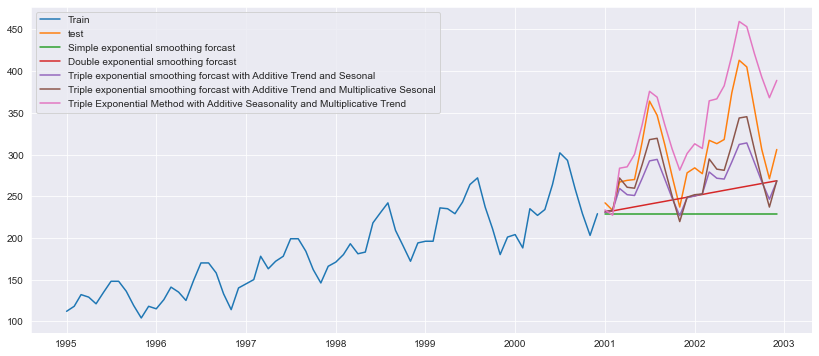

In [51]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

Observation
1. It captures the trend, which we can see that the forecasted values are higher level than the test level.
2. It also captures the seasonality.
3. The peak of the forecasted value is higher than the actual.

In [52]:
# Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Passengers))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Passengers)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 6.034483884370218 
 Train Root Mean Squared Error = 6.3967514247667365 
 Test Root Mean Squared Error = 23.05679851513917


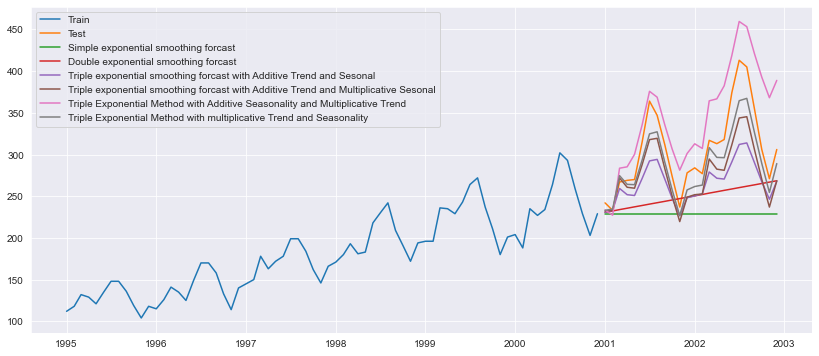

In [53]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [54]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0     Triple_Exp_mul    6.396751      6.034484         23.056799
1  Triple_Exp_mul_ad    6.386634      9.368355         34.989365
2      Triple_Exp_ad    7.751304     12.084509         47.569283
3  Triple_Exp_ad_mul   12.749205     12.932828         46.728647
4         Double_Exp   18.961290     17.148982         71.634643
5         Simple_Exp   19.031772     23.382283         91.113254

#### Visualizing Models Performance

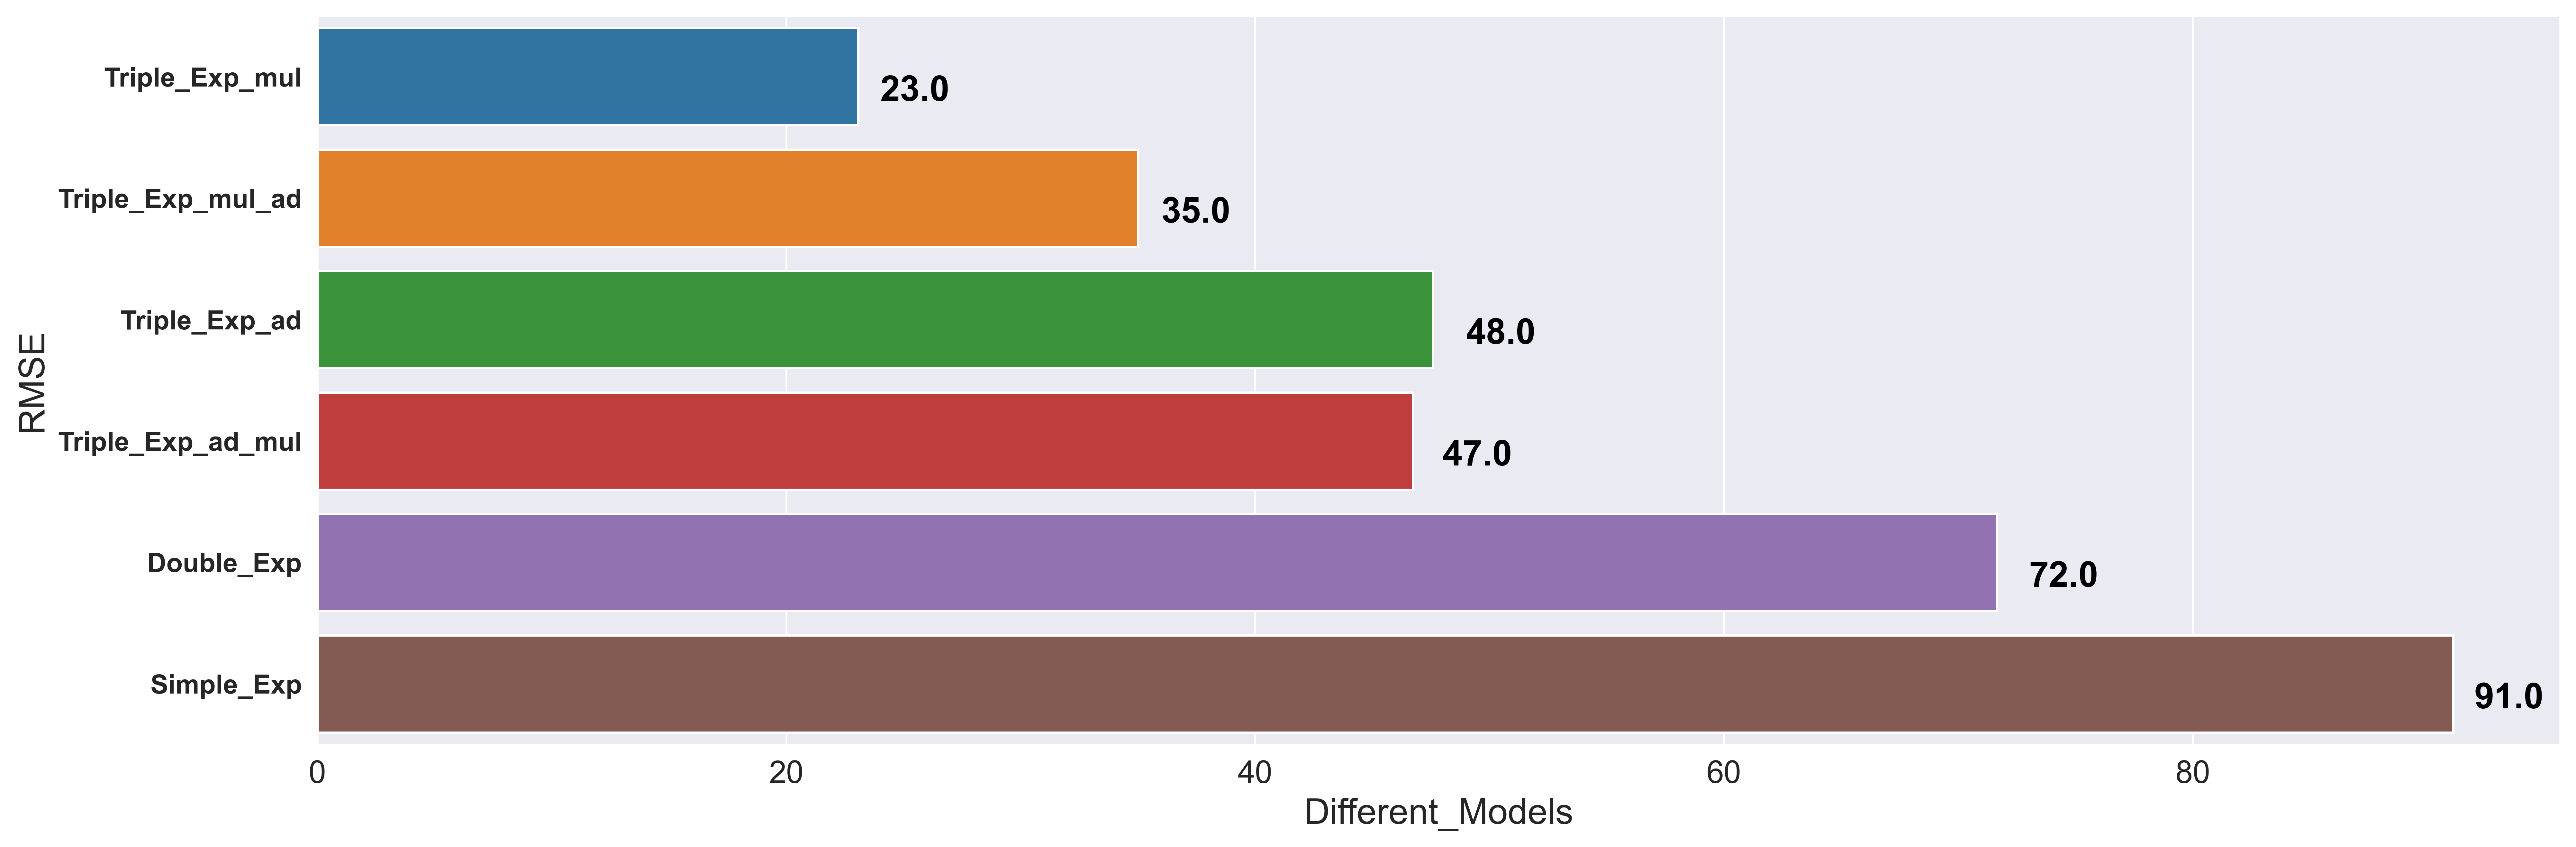

In [55]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

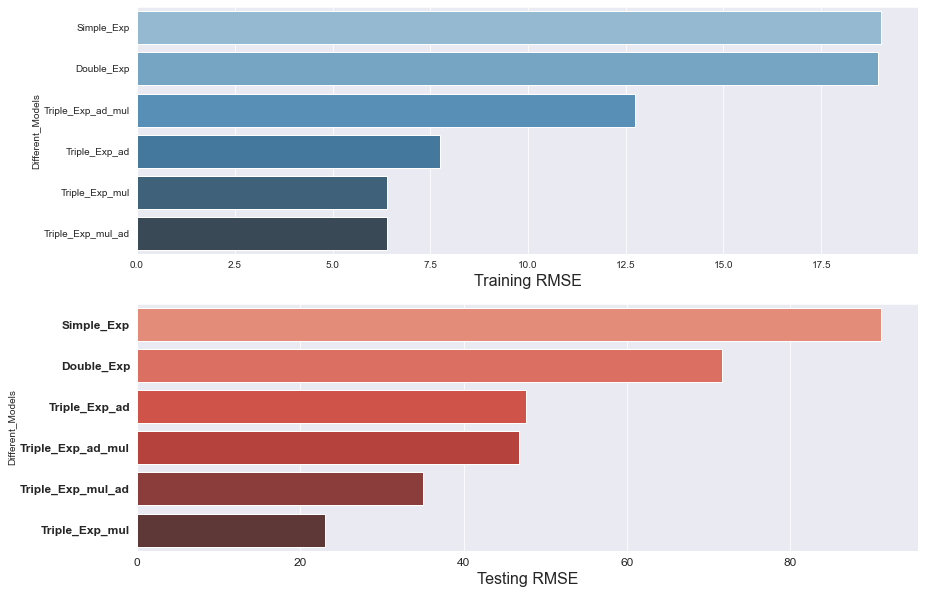

In [56]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

#### Autoregressive Integrated Moving Averages (ARIMA)
#### Stationary vs Non-stationary Time Series

In [57]:
# Test of Stationarity
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### Augmented Dickey Fuller Test

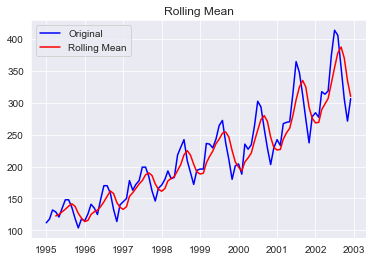

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [58]:
sales= pd.DataFrame()
sales['Passengers'] = df1[['Passengers']]
test_stationarity(sales)

In [59]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [60]:
adf_test(sales)

Fail to reject the null hypothesis
Data is non-stationary


#### Feature Scaling (Transformations)

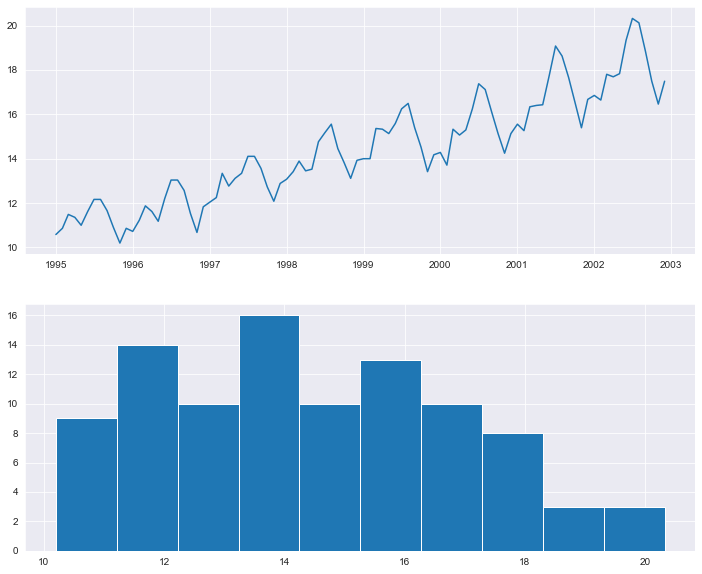

In [61]:
# Square Root Transform
square_root= pd.DataFrame()
square_root = df1[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

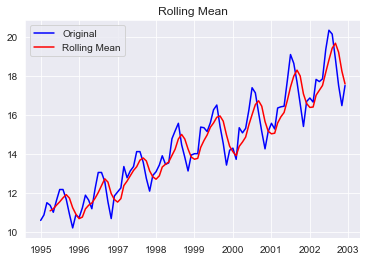

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [62]:
test_stationarity(square_root)

In [63]:
adf_test(square_root)

Fail to reject the null hypothesis
Data is non-stationary


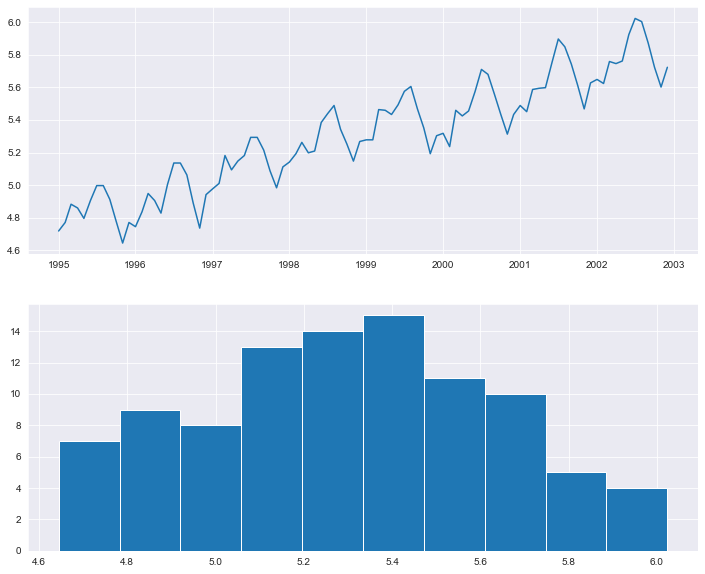

In [64]:
# Log Transform
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

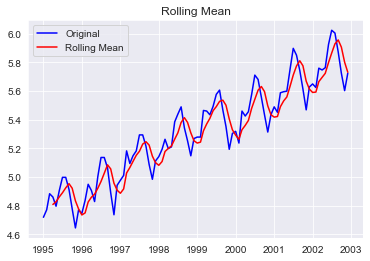

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [65]:
test_stationarity(log)

In [66]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


Hence, the Time series data is Non-Stationary

#### Converting Non-Stationary Time Series into Stationary

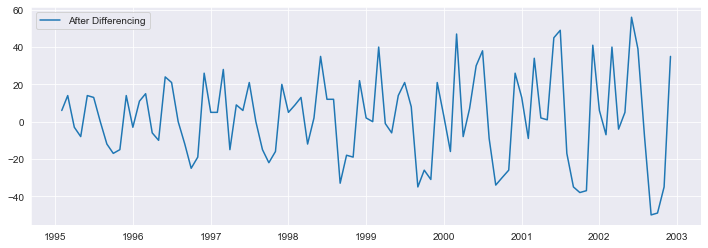

In [67]:
# Differencing
differencing = df1 - df1.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

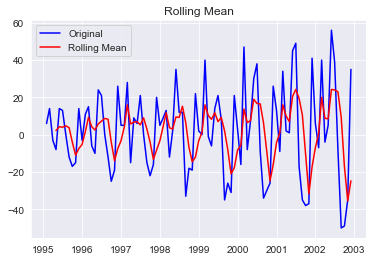

Results of Dickey Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [68]:
test_stationarity(differencing)

In [69]:
adf_test(differencing)

Fail to reject the null hypothesis
Data is non-stationary


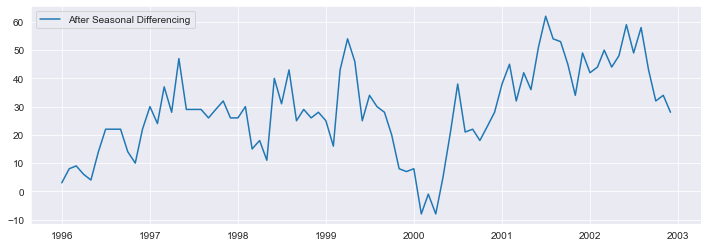

In [70]:
# Seasonal Differencing
seasonal_differencing = df1 - df1.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

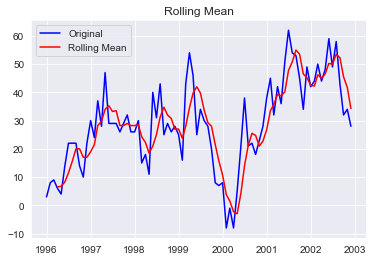

Results of Dickey Fuller Test:
Test Statistic                 -2.690004
p-value                         0.075784
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [71]:
test_stationarity(seasonal_differencing)

In [72]:
adf_test(seasonal_differencing)

Fail to reject the null hypothesis
Data is non-stationary


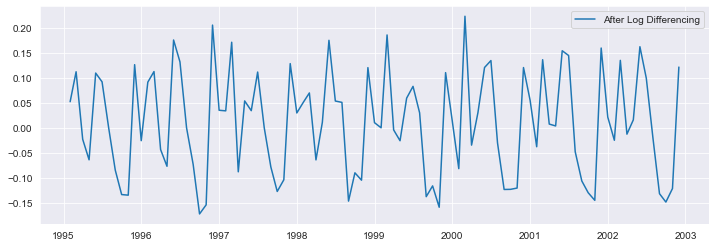

In [73]:
# Transformation
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

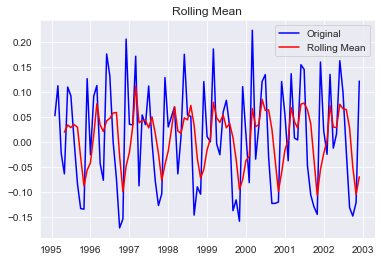

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [90]:
test_stationarity(log_diff)

In [75]:
adf_test(log_diff.Passengers)

Fail to reject the null hypothesis
Data is non-stationary


Passengers
Date                  
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791

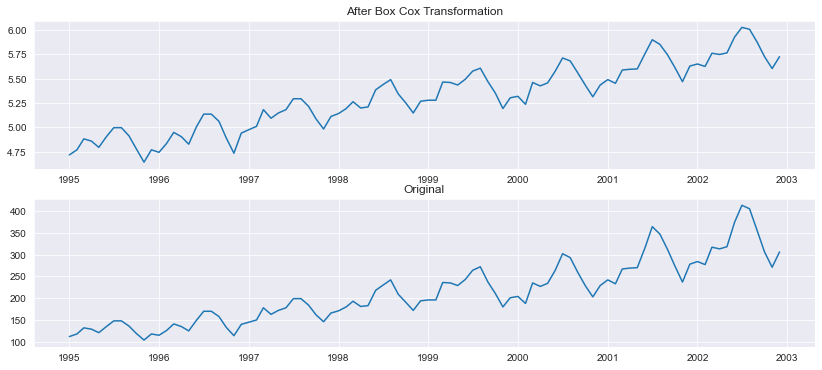

In [76]:
# Box Cox Transformation
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(df1['Passengers'], lmbda=0), df1.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df1, label='original')
axis[1].set_title('Original')
plt.show()

Observation
1. We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.
2. But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do `Differencing` for making the mean constant.

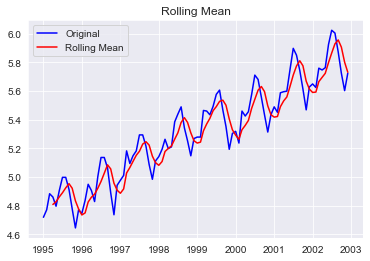

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [77]:
test_stationarity(data_boxcox)

In [78]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


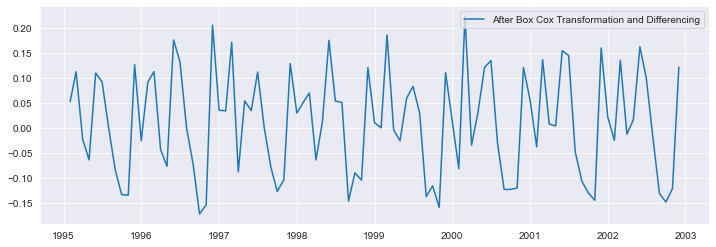

In [79]:
# Differencing of the Box-Cox Transformation
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
#data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

Observation
1. We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation. 
2. It is a horizontal trend.
3. The mean became constant. The mean is zero.
4. Also, the variance is almost constant.

Lets test the Stationarity again.

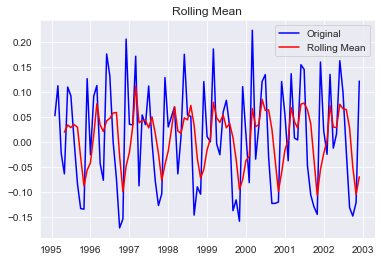

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [87]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [88]:
adf_test(data_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


 Finally, Our Series is now stationary for AR Forecasting

#### ARIMA Hyperparameter Tuning

In [82]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [83]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [84]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(data_boxcox_diff.Passengers, p_values, d_values, q_values)

KeyboardInterrupt: 

In [ ]:
# Building The Time Series Forecasting with Optimal Value using ARIMA
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

In [ ]:
# Inverse transformation of the Box-Cox Differencing 
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

Observation
1. We can see that we have done moderately well.
2. No Seasonality captured. Only Trend has been captured

#### Model Evaluation

In [ ]:
# RMSE (Root Mean Squared Error)
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

In [ ]:
# MAPE (Mean Absolute Percent Error)
mape_arima = round(np.mean(np.abs((test_data.Passengers - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_arima

Observation
1. We can see that AR model has done reasonably good job but not better than Holt's method.
2. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

In [ ]:
# Analysing the Residuals
# The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

In [ ]:
# Residuals must be stationary
adf_test(model_residual)

In [ ]:
# No autocorrelation between residuals
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

In [ ]:
# Residuals must be random
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Seasonal Auto Regressive Integrated Moving Average (SARIMA)
ARIMA with Seasonal component added.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [ ]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [ ]:
# Inverse Transformation of the Differencing Box-Cox Transformation
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

We can see that we are able to capture the trend and seasonality both.

#### Model Evaluation

In [ ]:
# RMSE (Root Mean Squared Error)
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

In [ ]:
# MAPE (Mean Absolute Percent Error)
mape_sarima = round(np.mean(np.abs((test_data.Passengers - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_sarima

Observation:
1. SARIMA method has done reasonably well as it captures seasonality.
2. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. |

In [ ]:
# Analysing the Residuals
model_residual = model_fit.resid
model_residual.mean()

In [ ]:
# Residuals must be stationary
adf_test(model_residual)

In [ ]:
# No autocorrelation between residuals
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

In [ ]:
# Residuals must be random
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Creating model with different Transformation Technique

In [ ]:
#Compareing the results 

Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

Observation:
+ The Sarima Model did very well as compared to other Models but Holts-Winter Method did slightly better
**Note:Sarima with Hyperparameter tuning may get better results**
+ Even in methods such as Triple Exponential Smoothing (Holts-Winters Method) taking Seasonality and Trend as Multiplicative gave the best restult in this case

#### Data Pre-processing for Model Driven Techniques

In [ ]:
# Creating Dummy Variables of the Categorical Feature Month of Date Time feature 
cocacola = df1.copy()
cocacola.reset_index(inplace=True)
cocacola['t'] = np.arange(1,len(cocacola)+1)
cocacola['t_squared'] = np.square(cocacola.t)
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(cocacola['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([cocacola,months],axis=1)
cocacola['log_passengers'] = np.log(cocacola['Passengers'])
cocacola

In [ ]:
# Splitting data into Train and Test 
train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [ ]:
train_data

In [ ]:
test_data

In [ ]:
# Building Ordinary Square Model 
# Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

In [ ]:
linear_model.summary()

In [ ]:
#Exponential

Exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

In [ ]:
Exp.summary()

In [ ]:
#Quadratic 

Quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

In [ ]:
Quad.summary()

In [ ]:
#Additive seasonality 

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

In [ ]:
add_sea.summary()

In [ ]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

In [ ]:
add_sea_Quad.summary()

In [ ]:
# Multiplicative Seasonality

Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

In [ ]:
Mul_sea.summary()

In [ ]:
# Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

In [ ]:
Mul_Add_sea.summary()

In [ ]:
np.exp(pred_Mult_add_sea)

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(np.exp(pred_Mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

In [ ]:
# Compare the results 

data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [ ]:
e = table_rmse.append(table_evaluation)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [ ]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()